In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import shap
import lime

In [2]:
data = pd.read_csv('data/nocountry.csv')

In [3]:
print(data.columns.tolist())
#print(data.head())
print(data.describe())
#print(data.info())

['spotify_id', 'name', 'artists', 'daily_rank', 'daily_movement', 'weekly_movement', 'country', 'snapshot_date', 'popularity', 'is_explicit', 'duration_ms', 'album_name', 'album_release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
         daily_rank  daily_movement  weekly_movement  country    popularity  \
count  20007.000000    20007.000000     20007.000000      0.0  20007.000000   
mean      25.492128        0.978308         3.165142      NaN     89.056280   
std       14.427529        7.482261        12.878384      NaN     10.977112   
min        1.000000      -33.000000       -48.000000      NaN      0.000000   
25%       13.000000       -1.000000        -3.000000      NaN     87.000000   
50%       25.000000        0.000000         0.000000      NaN     91.000000   
75%       38.000000        2.000000         6.000000      NaN     94.000000   
max       50.000000  

### PCA: 
Some discrete data is irrelavent with the rank, so we need to erase those features, and then add some hidden features into the dataset, for example, time period between release and hot.

First step is reshape the dataframe.

In [4]:
data['snapshot_date'] = pd.to_datetime(data['snapshot_date'])
data['album_release_date'] = pd.to_datetime(data['album_release_date'])

data['release_to_chart_days'] = (data['snapshot_date'] - data['album_release_date']).dt.days

data['month'] = data['snapshot_date'].dt.month

def month_to_spring(month):
    if month in [3, 4, 5]:
        return 1
    else:
        return 0
    
def month_to_summer(month):
    if month in [6, 7, 8]:
        return 1
    else:
        return 0
    
def month_to_autumn(month):
    if month in [9, 10, 11]:
        return 1
    else:
        return 0

def month_to_winter(month):
    if month in [12, 1, 2]:
        return 1
    else:
        return 0
    


data['spring'] = data['month'].apply(month_to_spring)
data['summer'] = data['month'].apply(month_to_summer)
data['winter'] = data['month'].apply(month_to_winter)
data['autumn'] = data['month'].apply(month_to_autumn)

data['loudness_tempo_interaction'] = data['loudness'] * data['tempo']

print(data.head())

               spotify_id                          name  \
0  5vNRhkKd0yEAg8suGBpjeY                          APT.   
1  2plbrEY59IikOBgBGLjaoe              Die With A Smile   
2  2CGNAOSuO1MEFCbBRgUzjd             luther (with sza)   
3  0nj9Bq5sHDiTxSHunhgkFb                   squabble up   
4  0aB0v4027ukVziUGwVGYpG  tv off (feat. lefty gunplay)   

                         artists  daily_rank  daily_movement  weekly_movement  \
0               ROSÉ, Bruno Mars           1               0                1   
1          Lady Gaga, Bruno Mars           2               0               -1   
2            Kendrick Lamar, SZA           3               0               47   
3                 Kendrick Lamar           4               0               46   
4  Kendrick Lamar, Lefty Gunplay           5               1               45   

   country snapshot_date  popularity  is_explicit  ...  valence    tempo  \
0      NaN    2024-11-27          98        False  ...    0.939  149.027   
1     

In [46]:
data_rank = data.copy()
data_last = data.copy()
data_season = data.copy()

In [47]:
columns_to_drop = ['spotify_id', 'month', 'name', 'country', 'artists', 'album_name', 'album_release_date', 'snapshot_date', 'key', 'mode', 'time_signature', 'spring', 'summer', 'winter', 'autumn', 'is_explicit']
for onecolumn in columns_to_drop:
    data_rank.drop(columns=onecolumn, inplace=True)
    
data_rank.fillna(data_rank.mean(), inplace=True)
data_rank.head()

,daily_rank,daily_movement,weekly_movement,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_to_chart_days,loudness_tempo_interaction
0,1,0,1,98,169917,0.777,0.783,-4.477,0.2600,0.0283,0.0,0.3550,0.939,149.027,40.0,-667.193879
1,2,0,-1,100,251667,0.521,0.592,-7.777,0.0304,0.3080,0.0,0.1220,0.535,157.969,103.0,-1228.524913
2,3,0,47,64,177598,0.707,0.575,-7.546,0.1250,0.2510,0.0,0.2480,0.576,138.008,6.0,-1041.408368
3,4,0,46,86,157992,0.874,0.672,-5.568,0.1980,0.0206,0.0,0.0783,0.711,103.921,5.0,-578.632128
4,5,1,45,85,220690,0.855,0.529,-6.679,0.2630,0.0837,0.0,0.4230,0.548,100.036,5.0,-668.140444


In [48]:
from sklearn.preprocessing import StandardScaler

features = [col for col in data_rank.columns if col != 'daily_rank']

scaler = StandardScaler()
data_rank_scaled = scaler.fit_transform(data_rank[features])


pca = PCA()
principal_components = pca.fit_transform(data_rank_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])

print("Explained Variance Ratio:", explained_variance_ratio)
print(explained_variance_ratio.sum())
pca_df['Daily Rank'] = data_rank['daily_rank']
print(pca_df.head())

Explained Variance Ratio: [0.23928485 0.11637151 0.09815037 0.0895295  0.07638022 0.0709149
 0.06218027 0.05542794 0.04446934 0.04150034 0.03955109 0.02599885
 0.0245089  0.01428641 0.00144552]
1.0000000000000002
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.121883  0.273875  1.885575  1.612519 -1.306525  0.971038 -0.991132   
1 -1.371167  0.936970  1.086562 -0.048539  0.563284 -1.041484  0.887239   
2 -0.504931 -3.135365  0.276043  1.151034 -0.686009 -0.172467 -0.426069   
3  1.863000 -1.950915 -0.692631  0.991182 -1.313739 -0.595060 -0.486082   
4  0.490385 -2.547927  0.836199 -0.021901 -2.230876  0.779023 -1.491162   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.813285 -0.022164  0.383744  0.553988 -0.359042 -1.048632 -0.399316   
1 -0.285053  0.071896 -0.359636  0.946082  0.437549 -0.489809  0.058773   
2 -0.118310  2.324986 -0.947807 -0.546427 -0.804565  0.000107 -0.138432   
3  0.953102  2.631903  0.956976 -0.1

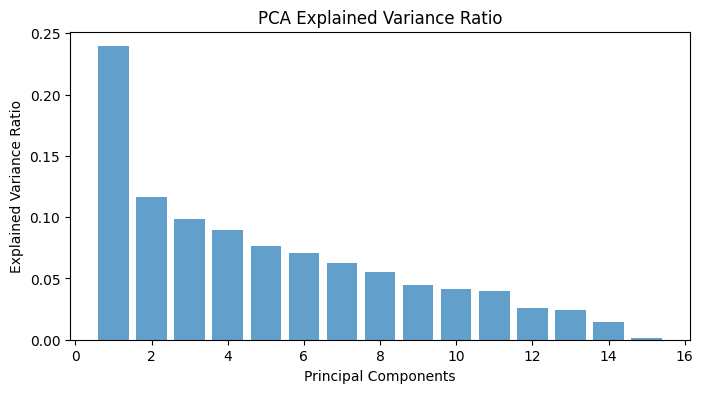

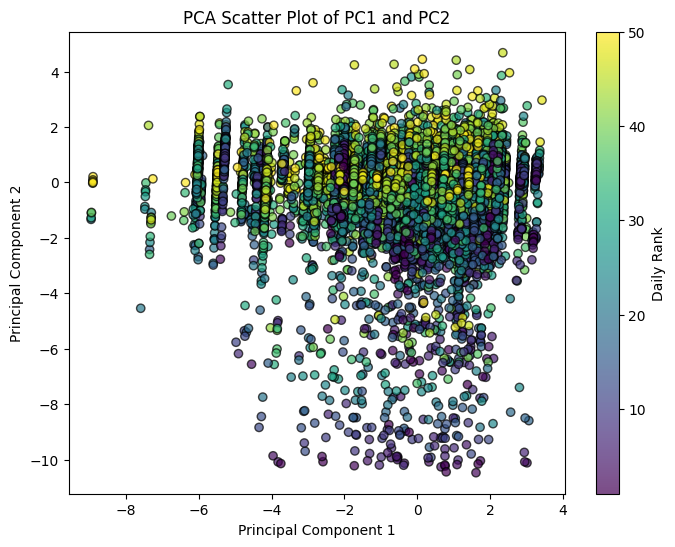

In [49]:
import matplotlib.pyplot as plt

# 绘制解释方差比例
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance Ratio')
plt.show()

# 散点图：比如，展示前两个主成分
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Daily Rank'], cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Daily Rank')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of PC1 and PC2')
plt.show()

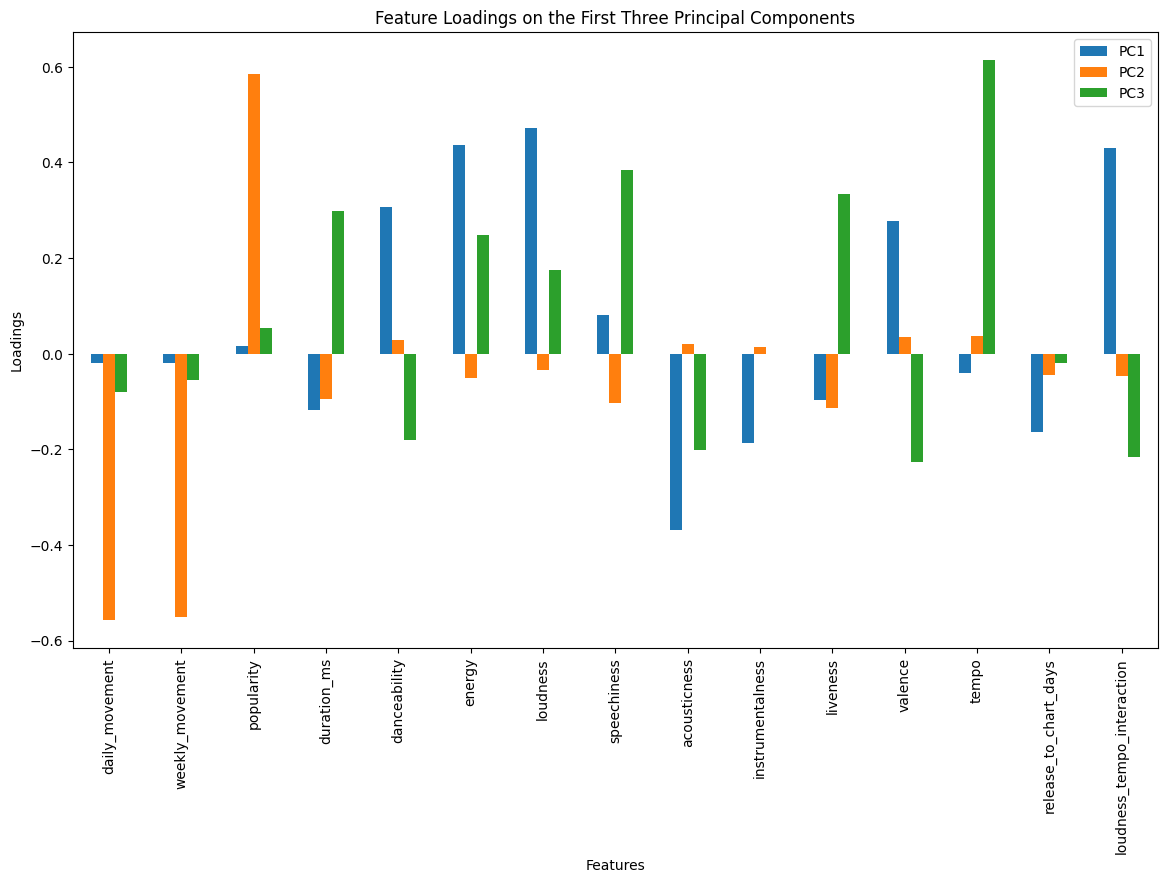

In [50]:
loadings = pca.components_.T
features = [col for col in data_rank.columns if col not in ['daily_rank']]

loadings_df = pd.DataFrame(loadings, index=features, columns=[f'PC{idx+1}' for idx in range(loadings.shape[1])])

loadings_df = loadings_df.iloc[:, :3]

ax = loadings_df.plot(kind='bar', figsize=(14, 8), title="Feature Loadings on the First Three Principal Components")
ax.set_ylabel("Loadings")
ax.set_xlabel("Features")
plt.show()

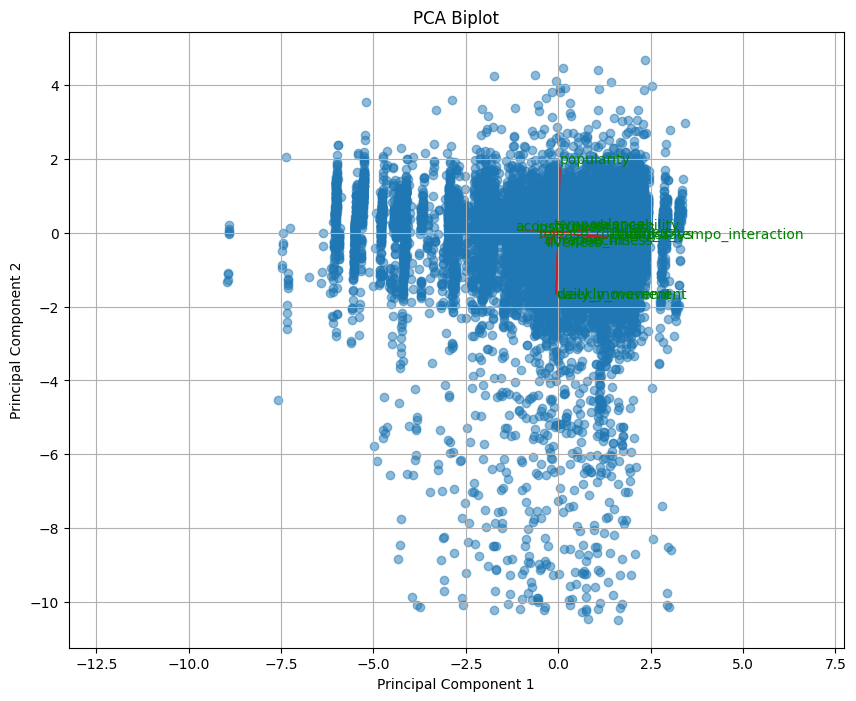

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5, label='Songs')
for i, feature in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1']*3, loadings_df.loc[feature, 'PC2']*3, color='r', alpha=0.5)
    plt.text(loadings_df.loc[feature, 'PC1']*3.2, loadings_df.loc[feature, 'PC2']*3.2, feature, color='g')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axis('equal')
plt.show()

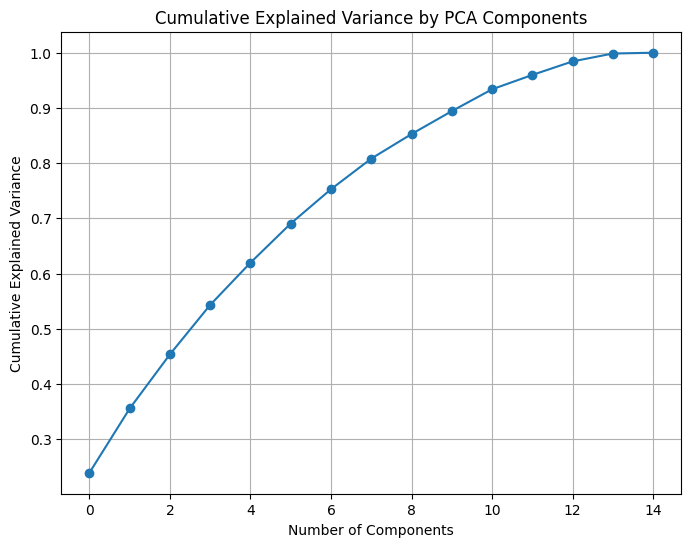

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

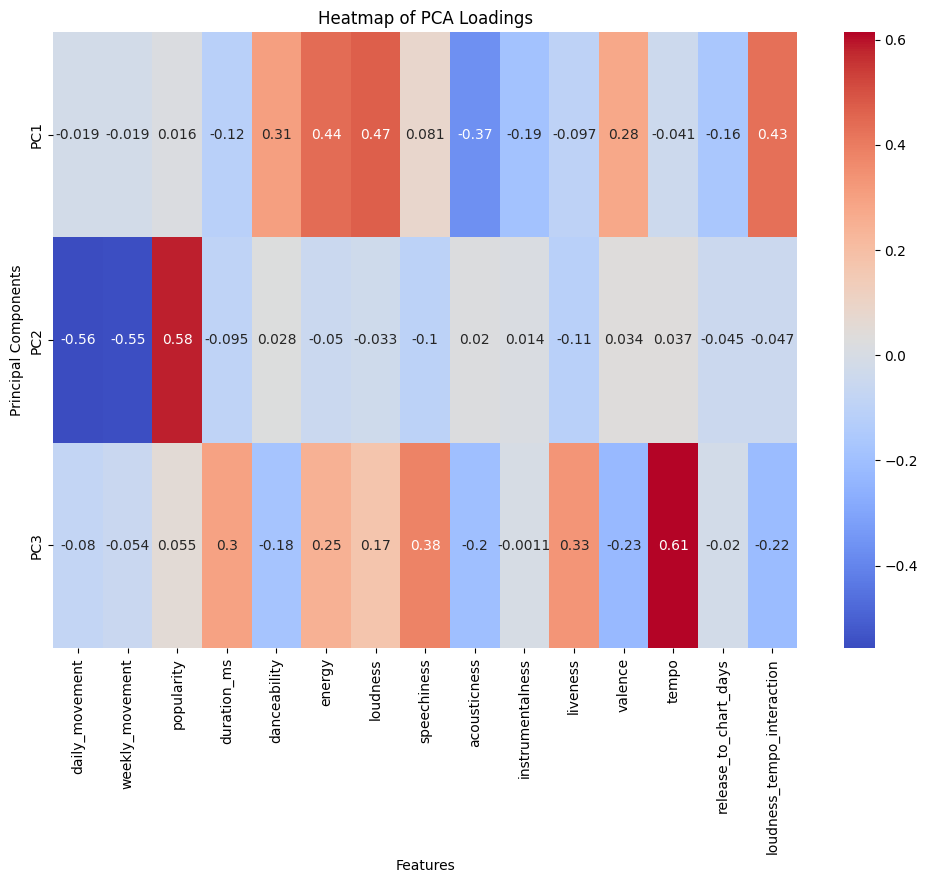

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df.T, cmap='coolwarm', annot=True)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()

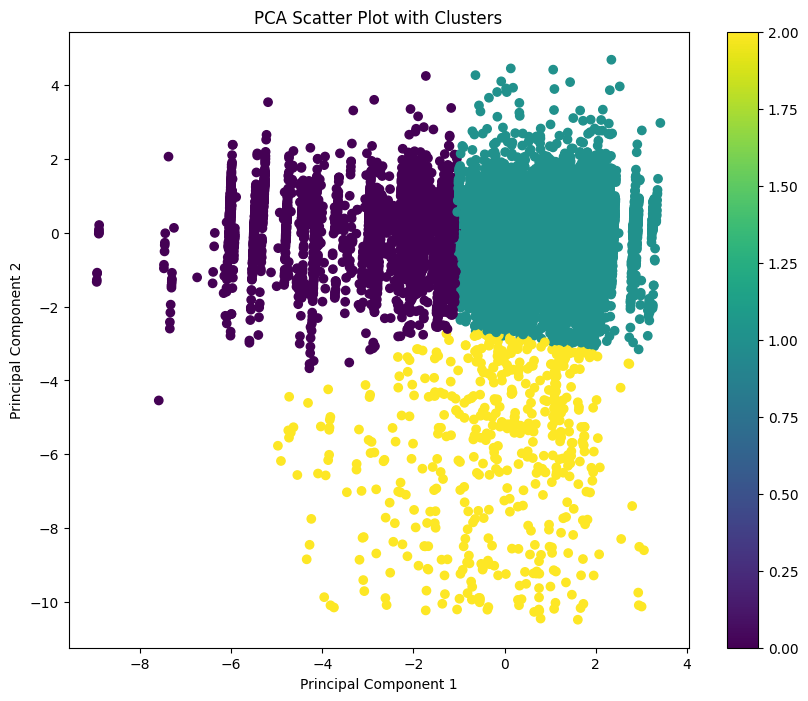

In [54]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(principal_components[:, :2])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Clusters')
plt.show()

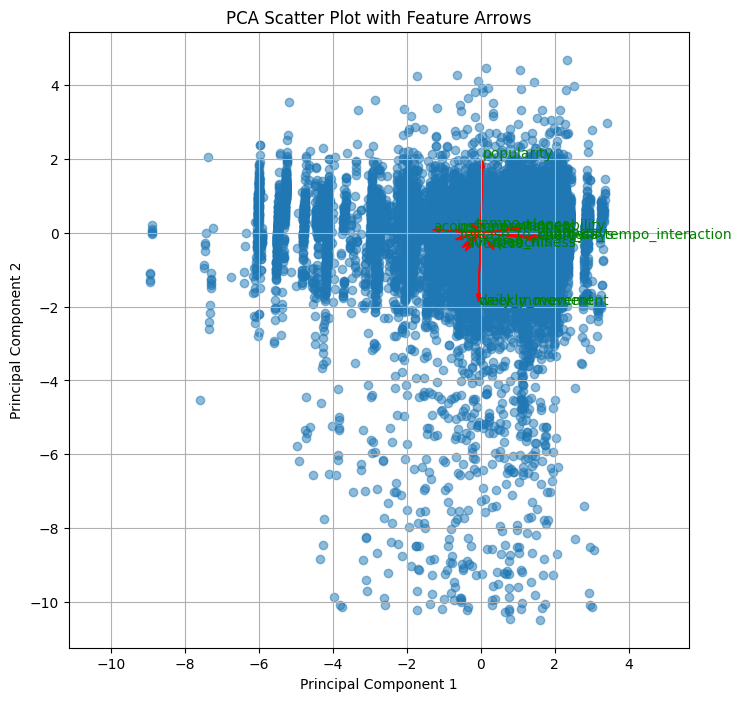

In [55]:
plt.figure(figsize=(8, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)

# 添加每个特征的箭头
for i, feature in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * 3, loadings_df.loc[feature, 'PC2'] * 3,
              head_width=0.1, head_length=0.2, color='red')
    plt.text(loadings_df.loc[feature, 'PC1'] * 3.5, loadings_df.loc[feature, 'PC2'] * 3.5,
             feature, color='green')

# 设置图表的标签和标题
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Feature Arrows')
plt.grid(True)
plt.axis('equal')  # 确保x轴和y轴具有相同的比例
plt.show()

In [56]:
import json

In [58]:
pca_json = {
    "scores": pca_df.to_dict(orient='records'), 
    "loadings": loadings_df.to_dict(orient='records') 
}

with open('pca_data.json', 'w') as json_file:
    json.dump(pca_json, json_file)

data_pca_df = pd.DataFrame(data=data_rank_scaled, columns=[col for col in data_rank.columns if col != 'daily_rank'])
json_rank_scaled =  data_pca_df.to_json(orient='records')

with open('data_rank_scaled.json', 'w') as f:
    f.write(json_rank_scaled)

In [59]:
data_json = data.to_json(orient='records')

with open('data.json', 'w') as f:
    f.write(data_json)